In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

In [2]:
dir_data = os.path.join("data", "processed")

path_train = os.path.join(dir_data, "train.csv")
path_val = os.path.join(dir_data, "validation.csv")
path_test = os.path.join(dir_data, "test.csv")

In [3]:
df_train = pd.read_csv(path_train)
df_val = pd.read_csv(path_val)
df_test = pd.read_csv(path_test)

In [4]:
df_train["mean_violent_prev_3mo"] = df_train[["violent_lag_1", "violent_lag_2",	"violent_lag_3"]].mean(axis=1)
df_val["mean_violent_prev_3mo"] = df_val[["violent_lag_1", "violent_lag_2",	"violent_lag_3"]].mean(axis=1)
df_test["mean_violent_prev_3mo"] = df_test[["violent_lag_1", "violent_lag_2", "violent_lag_3"]].mean(axis=1)

#df_train["log_median_household_income"] = np.log(df_train["median_household_income"])
#df_val["log_median_household_income"] = np.log(df_val["median_household_income"])
#df_test["log_median_household_income"] = np.log(df_test["median_household_income"])

#df_train["log_pop_total"] = np.log1p(df_train["pop_total"])
#df_val["log_pop_total"] = np.log1p(df_val["pop_total"])
#df_test["log_pop_total"] = np.log1p(df_test["pop_total"])

In [5]:
df_train.head()

,Unnamed: 0,ZCTA,incident_month_timestamp,crime_Non-Violent,crime_Violent,violent_lag_1,violent_lag_2,violent_lag_3,season,month_sin,month_cos,pop_total,median_household_income,gini_index,unemployment_rate,poverty_rate,mean_violent_prev_3mo
0,0,90001,2020-04-01,16.0,25.0,16.0,12.0,38.0,spring,8.660254e-01,-0.500000,56403,60751.0,0.416,0.096901,0.205254,22.000000
1,1,90001,2020-05-01,31.0,22.0,25.0,16.0,12.0,spring,5.000000e-01,-0.866025,56403,60751.0,0.416,0.096901,0.205254,17.666667
2,2,90001,2020-06-01,29.0,36.0,22.0,25.0,16.0,summer,1.224647e-16,-1.000000,56403,60751.0,0.416,0.096901,0.205254,21.000000
3,3,90001,2020-07-01,37.0,27.0,36.0,22.0,25.0,summer,-5.000000e-01,-0.866025,56403,60751.0,0.416,0.096901,0.205254,27.666667
4,4,90001,2020-08-01,24.0,29.0,27.0,36.0,22.0,summer,-8.660254e-01,-0.500000,56403,60751.0,0.416,0.096901,0.205254,28.333333


## Feature Selection and Data Prep

In [6]:
def prep_data(df, features, label, X_scaler, Y_scaler):
    # Shuffle
    indices = df.index.values.tolist()
    shuffled_indices = np.random.permutation(indices)
    df_shuffled = df.reindex(shuffled_indices)

    # Drop records with any nulls
    df_shuffled = df_shuffled.dropna()
    
    # Get features and label
    X = df_shuffled[features]
    Y = df_shuffled[label]

    # Scale data
    X_std = X_scaler.transform(X)
    Y_std = Y_scaler.transform(Y)

    return X_std, Y_std

In [7]:
features = ["mean_violent_prev_3mo"]#, "log_median_household_income"] #, "violent_lag_1", "pop_total", "month_sin", "month_cos"]
label = ["crime_Violent"]

# Features to scale
scale_cols = [col for col in features if col not in ["month_sin", "month_cos"]]

# Initialize scalers on training data
X_scaler = ColumnTransformer(
    transformers = [
        ("scaler", StandardScaler(), scale_cols)
        ],
    remainder = "passthrough"
    )
X_scaler.fit(df_train.dropna()[features])
Y_scaler = StandardScaler()
Y_scaler.fit(df_train.dropna()[label])

# Run data prep pipeline
X_train, Y_train = prep_data(df_train, features, label, X_scaler, Y_scaler)
X_val, Y_val = prep_data(df_val, features, label, X_scaler, Y_scaler)
X_test, Y_test = prep_data(df_test, features, label, X_scaler, Y_scaler)

In [8]:
# Target mean/std dev
print("Mean:", np.mean(df_train[["crime_Violent"]]))
print("Standard deviation:", np.std(df_train[["crime_Violent"]]))

Mean: 41.39522744220731
Standard deviation: crime_Violent    47.159224
dtype: float64


/opt/miniconda3/envs/env_207_project/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


### Linear regression

In [9]:
tf.random.set_seed(0)

def build_model(num_features, learning_rate):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(
        units = 1, # output dim
        input_shape = [num_features], # input dim
        use_bias = True, # use a bias (intercept) param
        kernel_initializer = tf.ones_initializer, # initialize params to 1
        bias_initializer = tf.ones_initializer, # initialize bias to 1
    ))
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer = optimizer, loss = "mse")
    
    return model

# Tried learning rates [0.0001, 0.001, 0.01, 0.1]
# LR = 0.0001 -> loss = 0.8595, val_loss = 0.9083
# LR = 0.001 -> loss = 0.1703, val_loss = 0.1623
# LR = 0.01 -> loss = 0.0515, val_loss = 0.0448
# LR = 0.1 -> loss = 0.0522, val_loss = 0.0450
model_lr = build_model(num_features = X_train.shape[1], learning_rate = 0.01)
fit_model_lr = model_lr.fit(x = X_train, y = Y_train,
                            epochs = 5,
                            validation_data = (X_val, Y_val))

Epoch 1/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 0.2650 - val_loss: 0.0612
Epoch 2/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 0.0534 - val_loss: 0.0461
Epoch 3/5
  1/119 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0290

/opt/miniconda3/envs/env_207_project/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 0.0515 - val_loss: 0.0454
Epoch 4/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 0.0515 - val_loss: 0.0453
Epoch 5/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 0.0515 - val_loss: 0.0453


In [10]:
weights, bias = model_lr.get_weights()
print("Feature coefficient (standardized):", weights)
print("Bias coefficient (standardized):", bias)
print("\n")
print("Training (standardized) MSE:", model_lr.evaluate(X_train, Y_train, verbose = 0))
print("Training (standardized) RMSE:", np.sqrt(model_lr.evaluate(X_train, Y_train, verbose = 0)))

print("Validation (standardized) MSE:", model_lr.evaluate(X_val, Y_val, verbose = 0))
print("Validation (standardized) RMSE:", np.sqrt(model_lr.evaluate(X_val, Y_val, verbose = 0)))

print("Test (standardized) MSE:", model_lr.evaluate(X_test, Y_test, verbose = 0))
print("Test (standardized) RMSE:", np.sqrt(model_lr.evaluate(X_test, Y_test, verbose = 0)))

Feature coefficient (standardized): [[0.9797333]]
Bias coefficient (standardized): [0.00106185]


Training (standardized) MSE: 0.05138382315635681
Training (standardized) RMSE: 0.226680001668336
Validation (standardized) MSE: 0.045328833162784576
Validation (standardized) RMSE: 0.2129056907712534
Test (standardized) MSE: 0.05498742684721947
Test (standardized) RMSE: 0.23449398040721528


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


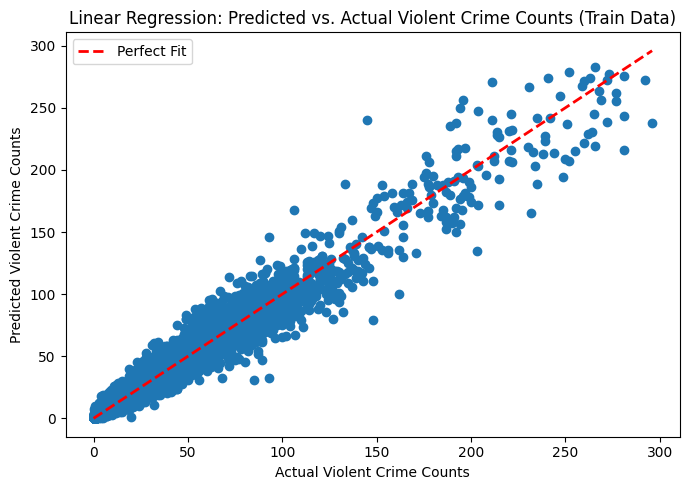

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


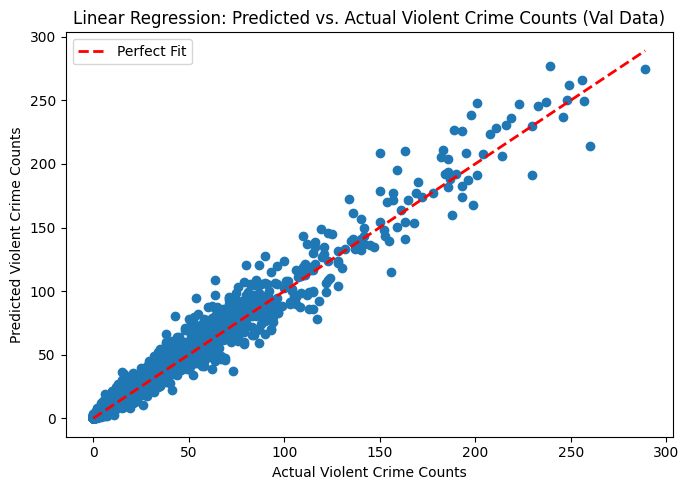

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


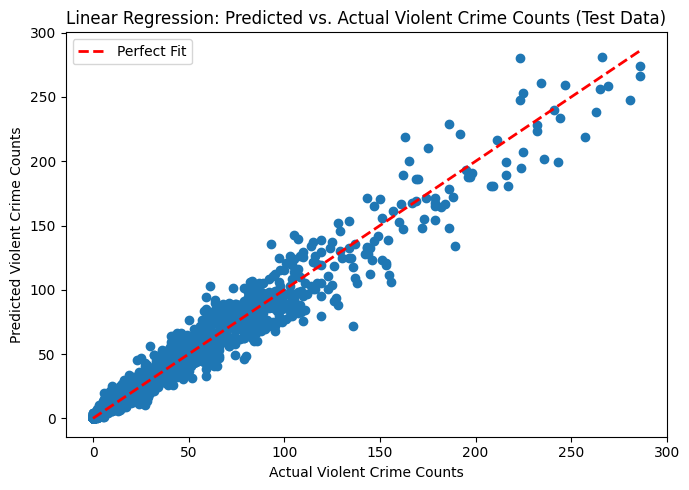

Train MSE (original scale): 116.33305320066984
Train RMSE (original scale): 10.78578013871365
Train MAE (original scale): 6.828698229773965
Validation MSE (original scale): 102.62453578277305
Validation RMSE (original scale): 10.130376882563306
Validation MAE (original scale): 6.543380644893835
Test MSE (original scale): 124.49157012077109
Test RMSE (original scale): 11.157579043895279
Test MAE (original scale): 7.270733988379675


In [11]:
# Revert scale and calculate MSE
def evaluate_rescale(X_std, Y_std, Y_scaler, split_name):
    Y_pred_std = model_lr.predict(X_std).reshape(-1, 1)
    Y_pred_orig = Y_scaler.inverse_transform(Y_pred_std)
    
    Y_true_std = np.array(Y_std).reshape(-1, 1)
    Y_true_orig = Y_scaler.inverse_transform(Y_true_std)
    
    mse_orig = mean_squared_error(Y_true_orig, Y_pred_orig)
    rmse_orig = np.sqrt(mse_orig)
    mae_orig = mean_absolute_error(Y_true_orig, Y_pred_orig)

    residuals = Y_true_orig - Y_pred_orig
    
    plt.figure(figsize=(7,5))
    plt.scatter(Y_true_orig, Y_pred_orig)
    
    min_val = min(Y_true_orig.min(), Y_pred_orig.min())
    max_val = max(Y_true_orig.max(), Y_pred_orig.max())
    plt.plot([min_val, max_val], [min_val, max_val],
            color = "red",
            linestyle = "--",
            linewidth = 2,
            label = "Perfect Fit")
    
    plt.xlabel("Actual Violent Crime Counts")
    plt.ylabel("Predicted Violent Crime Counts")
    plt.title(f"Linear Regression: Predicted vs. Actual Violent Crime Counts ({split_name} Data)")
    plt.legend()
    plt.tight_layout()
    
    plt.show()

    return mse_orig, rmse_orig, mae_orig

mse_train, rmse_train, mae_train = evaluate_rescale(X_train, Y_train, Y_scaler, "Train")
mse_val, rmse_val, mae_val = evaluate_rescale(X_val, Y_val, Y_scaler, "Val")
mse_test, rmse_test, mae_test = evaluate_rescale(X_test, Y_test, Y_scaler, "Test")

print(f"Train MSE (original scale): {mse_train}")
print(f"Train RMSE (original scale): {rmse_train}")
print(f"Train MAE (original scale): {mae_train}")

print(f"Validation MSE (original scale): {mse_val}")
print(f"Validation RMSE (original scale): {rmse_val}")
print(f"Validation MAE (original scale): {mae_val}")

print(f"Test MSE (original scale): {mse_test}")
print(f"Test RMSE (original scale): {rmse_test}")
print(f"Test MAE (original scale): {mae_test}")

### Random Forest

Random forest is a little better with population and the month sin/cos transformations, but a bit more overfitting (minor, but if we have generalizable models with the same validation accuracy don't think we would care about the better training performance?)

In [12]:
features = ["violent_lag_1", "violent_lag_2", "violent_lag_3"]#, "month_sin", "month_cos"]
label = ["crime_Violent"]

X_train = df_train[features]
Y_train = df_train[label].values.ravel()

X_val = df_val[features]
Y_val = df_val[label].values.ravel()

X_test = df_test[features]
Y_test = df_test[label].values.ravel()

In [13]:
model_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=1234,
    n_jobs=-1
)
model_rf.fit(X_train, Y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [14]:
Y_pred_train = model_rf.predict(X_train)
mse_train = mean_squared_error(Y_train, Y_pred_train)

Y_pred_val = model_rf.predict(X_val)
mse_val = mean_squared_error(Y_val, Y_pred_val)

Y_pred_test = model_rf.predict(X_test)
mse_test = mean_squared_error(Y_test, Y_pred_test)

print("Training (standardized) RMSE:", np.sqrt(mse_train))
print("Validation (standardized) RMSE:", np.sqrt(mse_val))
print("Test (standardized) RMSE:", np.sqrt(mse_test))

Training (standardized) RMSE: 6.775312159610979
Validation (standardized) RMSE: 10.810482196690764
Test (standardized) RMSE: 11.105835893639625


### Gradient Boosting

In [15]:
model_gb = GradientBoostingRegressor(loss="absolute_error",
                                learning_rate=0.01,
                                n_estimators=100,
                                max_depth = 10, 
                                random_state = 1234,
                                max_features = 5)
model_gb.fit(X_train, Y_train)

,loss,'absolute_error'
,learning_rate,0.01
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,10
,min_impurity_decrease,0.0
,init,None


In [16]:
Y_pred_train = model_gb.predict(X_train)
mse_train = mean_squared_error(Y_train, Y_pred_train)

Y_pred_val = model_gb.predict(X_val)
mse_val = mean_squared_error(Y_val, Y_pred_val)

Y_pred_test = model_gb.predict(X_test)
mse_test = mean_squared_error(Y_test, Y_pred_test)

print("Training (standardized) RMSE:", np.sqrt(mse_train))
print("Validation (standardized) RMSE:", np.sqrt(mse_val))
print("Test (standardized) RMSE:", np.sqrt(mse_test))

Training (standardized) RMSE: 28.737703259438863
Validation (standardized) RMSE: 29.27517778117197
Test (standardized) RMSE: 32.58078949981394


## XGBoost

In [17]:
model_xgb = XGBRegressor(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.5,
    random_state=1234,
    n_jobs=-1,
    objective="reg:squarederror")
model_xgb.fit(X_train, Y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [18]:
Y_pred_train = model_xgb.predict(X_train)
mse_train = mean_squared_error(Y_train, Y_pred_train)

Y_pred_val = model_xgb.predict(X_val)
mse_val = mean_squared_error(Y_val, Y_pred_val)

Y_pred_test = model_xgb.predict(X_test)
mse_test = mean_squared_error(Y_test, Y_pred_test)

print("Training (standardized) RMSE:", np.sqrt(mse_train))
print("Validation (standardized) RMSE:", np.sqrt(mse_val))
print("Test (standardized) RMSE:", np.sqrt(mse_test))

Training (standardized) RMSE: 8.76144913255868
Validation (standardized) RMSE: 10.871311888621051
Test (standardized) RMSE: 11.72599283951275


In [19]:
model_xgb.feature_importances_

array([0.37119022, 0.4187548 , 0.21005496], dtype=float32)